<a href="https://colab.research.google.com/github/lynxoo/ue-wroc-sad/blob/master/SAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statystyczna Analiza Danych
## Analiza Szkockich Whisky

Autorzy projektu:
* Łukasz Fąfara
* Artur Malarz

In [0]:
import pandas as pd
scotch = pd.read_csv(r'https://github.com/lynxoo/ue-wroc-sad/raw/master/scotch_review.csv')

In [187]:
scotch.head(5)

,Unnamed: 0,name,category,review.point,price,currency,description
0,1,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97,225,$,"Magnificently powerful and intense. Caramels, dried peats, elegant cigar smoke, seeds scraped from vanilla beans, brand new pencils, peppercorn, coriander seeds, and star anise make for a deeply satisfying nosing experience. Silky caramels, bountiful fruits of ripe peach, stewed apple, orange pith, and pervasive smoke with elements of burnt tobacco. An abiding finish of smoke, dry spices, and banoffee pie sweetness. Close to perfection. Editor's Choice"
1,2,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97,4500.00,$,"What impresses me most is how this whisky evolves; it's incredibly complex. On the nose and palate, this is a thick, viscous, whisky with notes of sticky toffee, earthy oak, fig cake, roasted nuts, fallen fruit, pancake batter, black cherry, ripe peach, dark chocolate-covered espresso bean, polished leather, tobacco, a hint of wild game, and lingering, leafy damp kiln smoke. Flavors continue on the palate long after swallowing. This is what we all hope for (and dream of) in an older whisky!"
2,3,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97,13500.00,$,"There have been some legendary Bowmores from the mid-60s and this is every bit their equal. All of them share a remarkable aroma of tropical fruit, which here moves into hallucinatory intensity: guava, mango, peach, pineapple, grapefruit. There’s a very light touch of peat smoke, more a memory of Islay than the reality. Concentrated; even at low strength the palate is silky, heady, and haunting, and lasts forever in the dry glass. A legend is born. (Eight bottles only for the U.S.) Editor's Choice."
3,4,"Compass Box The General, 53.4%",Blended Malt Scotch Whisky,96,325,$,"With a name inspired by a 1926 Buster Keaton movie, only 1,698 bottles produced, and the news that one of the two batches is more than 30 years old, the clues were there that this blend was never going to be cheap. It isn't, but it's superb, rich in flavor that screams dusty old oak office, fresh polish, and Sunday church, with spices, oak dried fruits, squiggly raisins, and a surprising melting fruit-and-nut dairy chocolate back story."
4,5,"Chivas Regal Ultis, 40%",Blended Malt Scotch Whisky,96,160,$,"Captivating, enticing, and wonderfully charming, this first blended malt from Chivas Regal contains selections of five Speyside malts: Strathisla, Longmorn, Tormore, Allt-a-Bhainne, and Braeval. Red apple, cherry, raspberry fudge, peach and mango fruit salad, dusting of cinnamon, and dry heather sprigs. In essence, it’s rich and satisfying, with dark vanilla, apricot, Bourneville-covered Brazil nuts, and tangerine, smoothed over by caramel and wood spices, maltiness, and gingersnap biscuits. Quite heavenly. Editor's Choice"


In [188]:
scotch.drop(['currency', 'Unnamed: 0', 'description'], axis=1, inplace=True)
scotch.head(5)

,name,category,review.point,price
0,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97,225
1,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97,4500.00
2,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97,13500.00
3,"Compass Box The General, 53.4%",Blended Malt Scotch Whisky,96,325
4,"Chivas Regal Ultis, 40%",Blended Malt Scotch Whisky,96,160


In [189]:
scotch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2247 entries, 0 to 2246
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          2247 non-null   object
 1   category      2247 non-null   object
 2   review.point  2247 non-null   int64 
 3   price         2247 non-null   object
dtypes: int64(1), object(3)
memory usage: 70.3+ KB


Parsowanie ceny

In [190]:
def parse_price(text):
  try:
    return float(text)
  except:
    pass
  return None
scotch['price'] = [parse_price(price) for price in scotch['price']]
scotch['price'].isnull().value_counts()

False    2228
True     19  
Name: price, dtype: int64

In [191]:
scotch.dropna(inplace=True)
scotch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2228 entries, 0 to 2246
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          2228 non-null   object 
 1   category      2228 non-null   object 
 2   review.point  2228 non-null   int64  
 3   price         2228 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 87.0+ KB


Parsowanie zawartości alkoholu

In [192]:
scotch_abv_test = scotch.copy()

import re
def parse_alcohol(text):
  matches = re.search(r"([\d.]+)%", str(text))
  return float(matches.group(1)) if matches else None

scotch_abv_test['abv'] = [parse_alcohol(name) for name in scotch_abv_test['name']]
scotch_abv_test.isnull().sum()

name            0 
category        0 
review.point    0 
price           0 
abv             16
dtype: int64

In [193]:
scotch_abv_test[scotch_abv_test['abv'].isnull()]

,name,category,review.point,price,abv
91,Ardbeg An Oa,Single Malt Scotch,93,60.0,NaN
93,"Balvenie 1973 Vintage, 30 year old, Cask #9219",Single Malt Scotch,93,400.0,NaN
189,"Bowmore Oloroso Sherry Cask, 1964 Vintage",Single Malt Scotch,92,1500.0,NaN
309,Scott,Single Malt Scotch,91,130.0,NaN
388,Compass Box Hedonism Maximus,Grain Scotch Whisky,90,300.0,NaN
612,Cadenhead,Single Malt Scotch,89,125.0,NaN
640,Glenfarclas £511. 19s. 0d.,Single Malt Scotch,89,130.0,NaN
668,Murray McDavid,Single Malt Scotch,89,150.0,NaN
909,Wemyss Malts ‘Honey Spice’ (distilled at Bunnahabhain) 1991 (bottled 2011),Single Malt Scotch,88,96.0,NaN
984,"Cask & Thistle (distilled at Aberfeldy), 29 year old, 1974 Vintage",Single Malt Scotch,87,110.0,NaN


In [194]:
scotch_abv_test.dropna(inplace=True)
scotch_abv_test.isnull().sum()

name            0
category        0
review.point    0
price           0
abv             0
dtype: int64

Weryfikacja danych


In [195]:
scotch_abv_test['abv'].describe()

count    2212.000000
mean     47.988603  
std      6.261953   
min      40.000000  
25%      43.000000  
50%      46.000000  
75%      52.200000  
max      100.000000 
Name: abv, dtype: float64

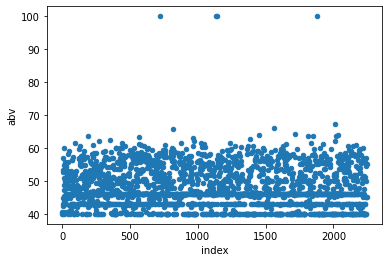

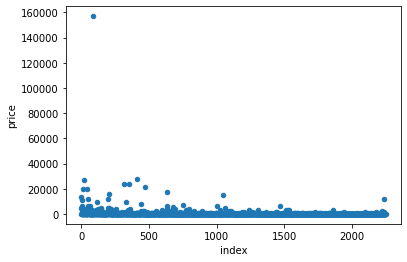

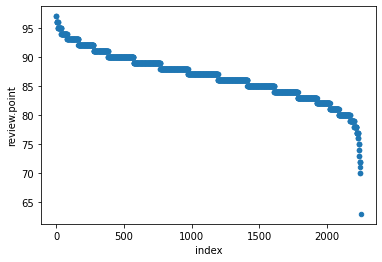

In [196]:
scotch_abv_test.reset_index().plot.scatter(x='index', y='abv')
scotch_abv_test.reset_index().plot.scatter(x='index', y='price')
scotch_abv_test.reset_index().plot.scatter(x='index', y='review.point')

Usuwamy odstające dane

In [197]:
q1 = scotch_abv_test.quantile(0.25)
q3 = scotch_abv_test.quantile(0.75)
 
iqr = q3 - q1
iqr

review.point    5.0  
price           130.0
abv             9.2  
dtype: float64

In [198]:
outliers = (scotch_abv_test < (q1 - 3.0 * iqr)) | (scotch_abv_test > (q3 + 3.0 * iqr))
outliers.sum()

abv             4  
category        0  
name            0  
price           210
review.point    1  
dtype: int64

In [199]:
scotch_abv_test[outliers.any(1)]

,name,category,review.point,price,abv
1,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97,4500.0,40.5
2,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97,13500.0,42.9
6,"Gold Bowmore, 1964 vintage, 42.4%",Single Malt Scotch,96,6250.0,42.4
7,"Bowmore, 40 year old, 44.8%",Single Malt Scotch,96,11000.0,44.8
8,"The Dalmore, 50 year old, 52.8%",Single Malt Scotch,96,1500.0,52.8
...,...,...,...,...,...
2177,"Gordon & MacPhail Private Collection: The Glenlivet Decades 1974, 50.1%",Single Malt Scotch,79,820.0,50.1
2218,"Auchentoshan 1962, 41 year old, 40.3%",Single Malt Scotch,77,2000.0,40.3
2236,"The Macallan Lalique Decanter, 55 year old, 40.1%",Single Malt Scotch,74,12000.0,40.1
2237,"Signatory (distilled at Kinclaith), Cask #301446, 35 year old, 1969 vintage, 51.3%",Single Malt Scotch,73,1700.0,51.3


In [0]:
# scotch_abv_test.reset_index().plot.scatter(x='index', y='abv', c={"b": outliers.any(1), "r": ~outliers.any(1)})

In [201]:
no_outliers = ~(outliers).any(axis=1)

scotch_abv_test._update_inplace(scotch_abv_test[no_outliers])
scotch_abv_test.describe()

,review.point,price,abv
count,1997.000000,1997.000000,1997.000000
mean,86.359539,134.379069,47.894537
std,3.878920,106.943213,5.934050
min,70.000000,12.000000,40.000000
25%,84.000000,65.000000,43.000000
50%,86.000000,100.000000,46.000000
75%,89.000000,159.000000,52.300000
max,97.000000,589.000000,67.400000


In [0]:
scotch_data = scotch_abv_test.copy()

## Rozkład wartości

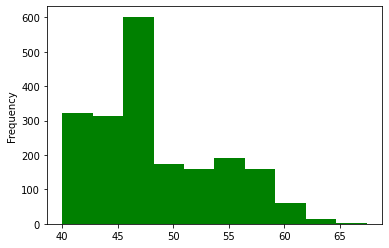

In [203]:
scotch_data['abv'].plot.hist(color='green')

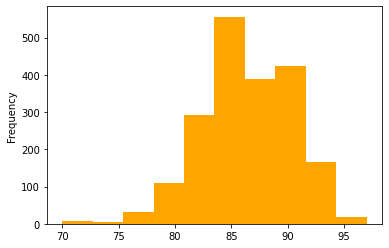

In [204]:
scotch_data['review.point'].plot.hist(color='orange')

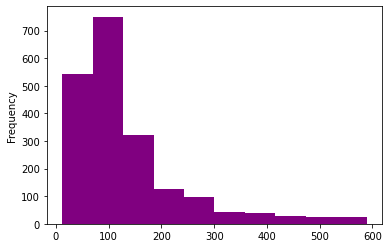

In [205]:
scotch_data['price'].plot.hist(color='purple')